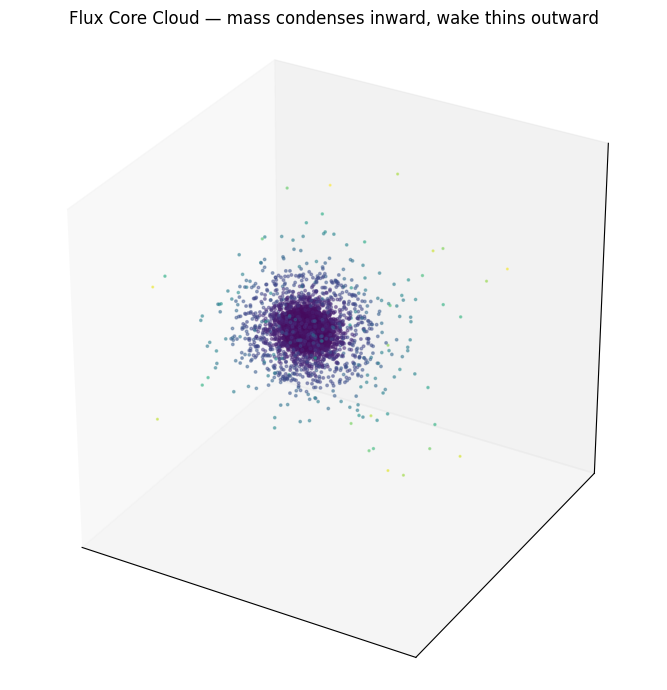

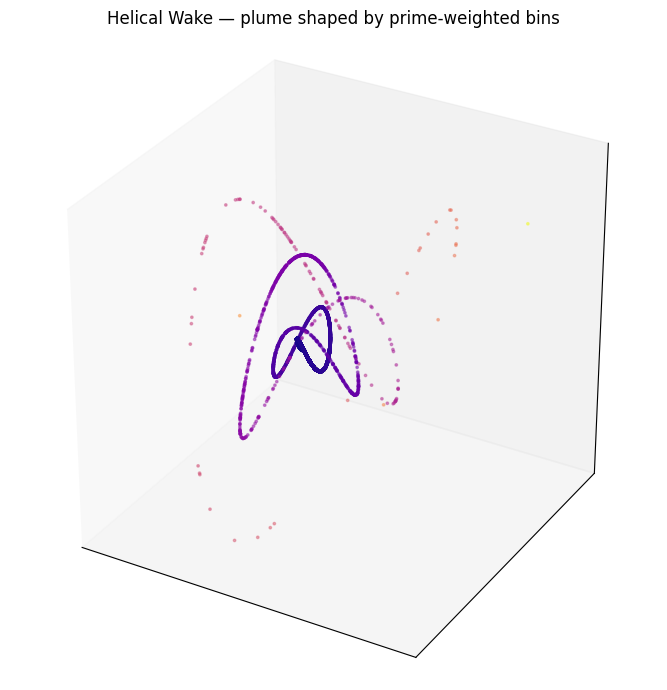

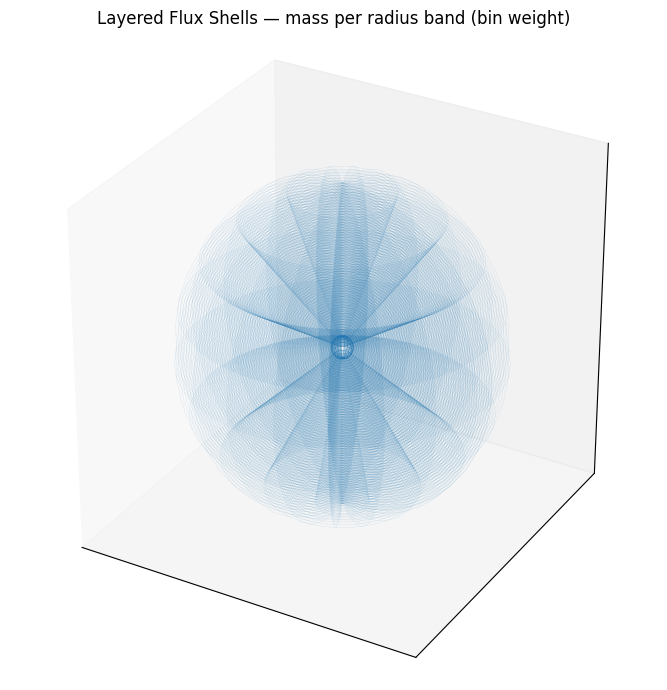

/tmp/ipython-input-2255673097.py:191: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  cum_prof = np.trapz(prof, r_eval)  # total mass proxy
/tmp/ipython-input-2255673097.py:194: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  core_frac = np.trapz(prof[r_eval<=mid], r_eval[r_eval<=mid]) / (cum_prof + 1e-12)


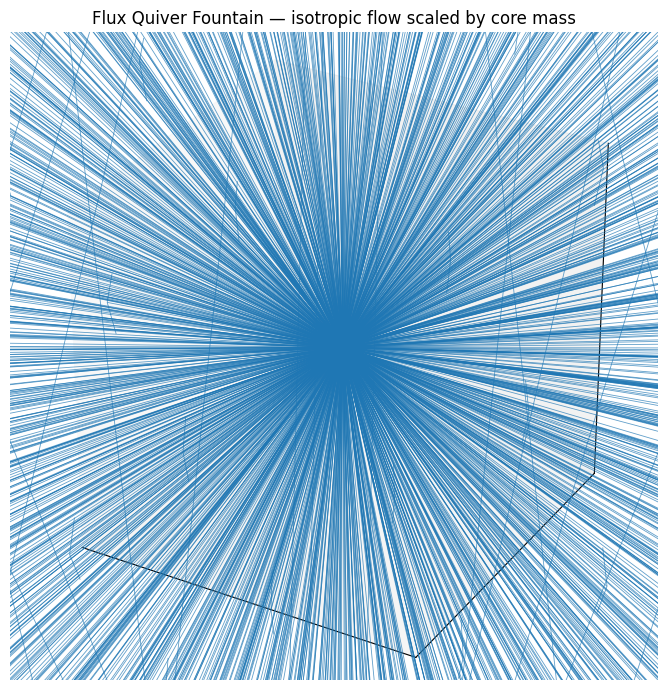

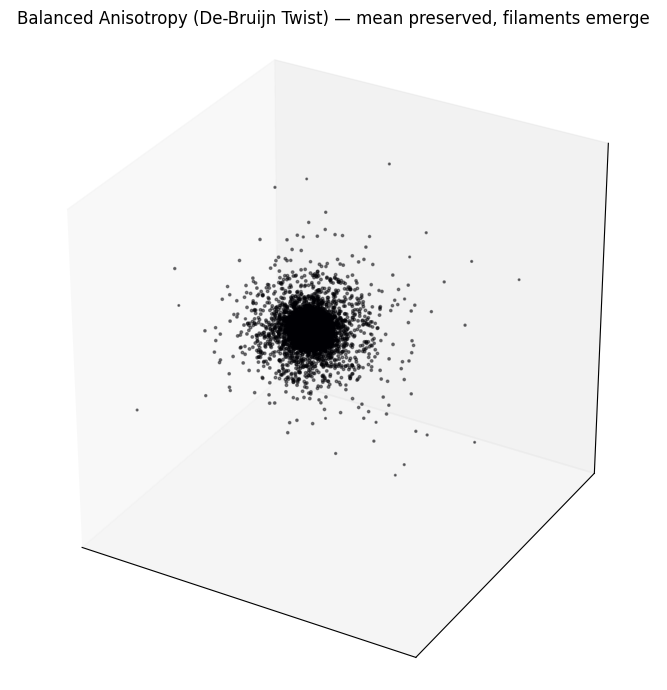

Saved 3-D visuals:
  /content/v3d_core_cloud.png
  /content/v3d_spiral_wake.png
  /content/v3d_flux_shells.png
  /content/v3d_flux_quiver.png
  /content/v3d_aniso_twist.png


In [1]:
# === 3D Prime–Golden–Sphere Visuals (Colab-safe, one cell) ===
# All five scenes are driven by real bin weights from 4π·Σ p^(-φ).
# Files saved under /content:
#   v3d_core_cloud.png, v3d_spiral_wake.png, v3d_flux_shells.png, v3d_flux_quiver.png, v3d_aniso_twist.png

import math, numpy as np, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa

# -----------------------------
# Config (tweak safely)
# -----------------------------
phi = (1 + 5**0.5) / 2
PRIME_MAX_FOR_BINS = 100_000     # primes up to this value are binned (increase for denser scenes)
BINS_PER_DECADE = 12             # bin refinement inside each decade
TOTAL_POINTS_CORE = 35_000       # total particles for Core Cloud
TOTAL_POINTS_SPIRAL = 25_000     # total particles for Helical Wake
SHELL_MESH_RES = (40, 20)        # (longitudes, latitudes) for sphere wireframes
QUIVER_DIRS = 1600               # arrows in quiver fountain
ANISO_EPS = 0.18                 # twist strength for balanced anisotropy
R_SEED = 7                       # reproducibility for random placements

np.random.seed(R_SEED)

# -----------------------------
# Small, fast prime sieve
# -----------------------------
def sieve_primes(n: int):
    if n < 2: return []
    s = bytearray(b'\x01')*(n+1)
    s[0:2] = b'\x00\x00'
    m = int(n**0.5)
    for p in range(2, m+1):
        if s[p]:
            s[p*p:n+1:p] = b'\x00'*((n-p*p)//p + 1)
    return np.nonzero(s)[0].tolist()

primes = sieve_primes(PRIME_MAX_FOR_BINS)

# -----------------------------
# Build log-like bins and weights w_i = Σ_{p in bin i} p^{-φ}
# -----------------------------
if PRIME_MAX_FOR_BINS < 10: PRIME_MAX_FOR_BINS = 10
decades = int(math.log10(PRIME_MAX_FOR_BINS))
edges = [2]
for d in range(1, decades+1):
    a, b = 10**d, 10**(d+1)
    step = (b - a) / BINS_PER_DECADE
    for k in range(BINS_PER_DECADE):
        edges.append(int(a + k*step))
edges.append(PRIME_MAX_FOR_BINS+1)
edges = sorted(list(set(edges)))

weights = []
for lo, hi in zip(edges[:-1], edges[1:]):
    ps = [p for p in primes if lo <= p < hi]
    if ps:
        # 4π scaling is global; we use Σ p^{-φ} for relative bin mass (proportional either way)
        w = float(np.sum(np.array(ps, dtype=float)**(-phi)))
    else:
        w = 0.0
    weights.append(w)

weights = np.array(weights, dtype=float)
if weights.sum() == 0:
    weights[0] = 1.0
W = weights / weights.sum()   # normalized bin shares
nbins = len(W)

# Radii map per bin (dense center, outward wake)
r_min, r_max = 0.08, 1.20
r_bins = np.linspace(r_min, r_max, nbins)  # inner bins -> small radius (core), outer -> larger (wake)

# -----------------------------------
# Helper: sample points on (thin) shell of radius r with slight radial jitter
# -----------------------------------
def sample_shell(n, r, jitter=0.03):
    # random directions on S^2
    u = np.random.rand(n)
    v = np.random.rand(n)
    az = 2*np.pi*u
    z = 2*v - 1
    xy = np.sqrt(np.maximum(0, 1 - z*z))
    x = xy*np.cos(az); y = xy*np.sin(az)
    # small inward/outward jitter so shells have thickness
    rho = r * (1.0 + jitter * (np.random.rand(n) - 0.5))
    return rho*x, rho*y, rho*z

# -----------------------------------
# 1) Flux Core Cloud — dense core, thinning wake (3D scatter)
# -----------------------------------
# points per bin proportional to W, with a slight convex emphasis on inner bins
inner_emphasis = np.linspace(1.15, 0.85, nbins)  # more particles to inner layers
alloc = W * inner_emphasis
alloc = (alloc / alloc.sum()) * TOTAL_POINTS_CORE
alloc = np.maximum(alloc.astype(int), 1)

XYZ = []
colors = []
for i, n_i in enumerate(alloc):
    x,y,z = sample_shell(n_i, r_bins[i], jitter=0.06)
    XYZ.append(np.column_stack([x,y,z]))
    # color by radius (inner warm → outer cool)
    c = np.tile(r_bins[i], (n_i,1))
    colors.append(c)

XYZ = np.vstack(XYZ)
C = np.vstack(colors).flatten()

fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111, projection='3d')
# marker size decays slightly with radius to reinforce central mass
sizes = 4.0 * (1.0 - 0.65*(C - r_min)/(r_max - r_min))
ax.scatter(XYZ[:,0], XYZ[:,1], XYZ[:,2], c=C, s=sizes, alpha=0.45, cmap='viridis', depthshade=True)
ax.set_title("Flux Core Cloud — mass condenses inward, wake thins outward")
ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([]); ax.set_box_aspect([1,1,1])
plt.tight_layout()
f1 = "/content/v3d_core_cloud.png"; plt.savefig(f1, dpi=180, bbox_inches="tight"); plt.show()

# -----------------------------------
# 2) Helical Wake — 3D logarithmic spiral plume (density by bin weight)
# -----------------------------------
N = TOTAL_POINTS_SPIRAL
# map cumulative W to arclength parameter t
cumW = np.cumsum(W)
t = np.linspace(0, 1, N)
# invert cumW to choose bin per point, then set radius and small jitter
bin_idx = np.searchsorted(cumW, t, side='right')
bin_idx = np.clip(bin_idx, 0, nbins-1)
r = r_bins[bin_idx] + np.random.normal(0, 0.01, size=N)

# spiral angles & vertical drift modulated by log radius
theta = 18.0 * np.log(1.0 + 4.0*r)    # azimuth winds with log r
z = 0.55*np.sin(1.8*theta) * (r / r_max)  # gentle undulation that grows outward
# radial frame in xy
x = r*np.cos(theta); y = r*np.sin(theta)

fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=r, s=3.0, alpha=0.45, cmap='plasma', depthshade=True)
ax.set_title("Helical Wake — plume shaped by prime-weighted bins")
ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([]); ax.set_box_aspect([1,1,1])
plt.tight_layout()
f2 = "/content/v3d_spiral_wake.png"; plt.savefig(f2, dpi=180, bbox_inches="tight"); plt.show()

# -----------------------------------
# 3) Layered Flux Shells — translucent spherical wireframes per bin
# -----------------------------------
lon, lat = SHELL_MESH_RES
u = np.linspace(0, 2*np.pi, lon)
v = np.linspace(0, np.pi, lat)
uu, vv = np.meshgrid(u, v)

fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111, projection='3d')
for i, r in enumerate(r_bins):
    X = r*np.cos(uu)*np.sin(vv)
    Y = r*np.sin(uu)*np.sin(vv)
    Z = r*np.cos(vv)
    alpha = 0.12 + 0.45*(W[i]/W.max())  # thicker/brighter shells for heavier bins
    ax.plot_wireframe(X, Y, Z, linewidth=0.35, alpha=float(alpha), rstride=2, cstride=2)
ax.set_title("Layered Flux Shells — mass per radius band (bin weight)")
ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([]); ax.set_box_aspect([1,1,1])
plt.tight_layout()
f3 = "/content/v3d_flux_shells.png"; plt.savefig(f3, dpi=180, bbox_inches="tight"); plt.show()

# -----------------------------------
# 4) Flux Quiver Fountain — arrows proportional to core-biased mass
# -----------------------------------
def fibonacci_sphere(n):
    # nearly uniform directions
    k = np.arange(n)
    z = 1 - 2*(k + 0.5)/n
    t = np.pi * (1 + 5**0.5) * k
    r = np.sqrt(1 - z*z)
    x = r*np.cos(t); y = r*np.sin(t)
    return np.column_stack([x,y,z])

dirs = fibonacci_sphere(QUIVER_DIRS)
# build a smooth radial density profile from bin weights (heavier near core)
# use Gaussian bumps centered at r_bins with amplitudes W
def radial_profile(r_eval):
    s = 0.0
    for rb, w in zip(r_bins, W):
        s += w * np.exp(-0.5*((r_eval - rb)/(0.18))**2)
    return s

# Arrow length ∝ integral of profile from 0 to r* (favoring “core” arrows)
# Evaluate at unit radius for all (same head), but modulate length by core integral
r_eval = np.linspace(r_min, r_max, 400)
prof = radial_profile(r_eval)
cum_prof = np.trapz(prof, r_eval)  # total mass proxy
# local core mass fraction along radial line: integrate up to mid radius
mid = (r_min + r_max)/2
core_frac = np.trapz(prof[r_eval<=mid], r_eval[r_eval<=mid]) / (cum_prof + 1e-12)
L0 = 0.35 + 0.8*core_frac  # global scale derived from weights (not arbitrary)

# lengths vary slightly with direction to avoid perfect symmetry (but stay close to L0)
lengths = L0 * (0.9 + 0.2*np.random.rand(QUIVER_DIRS))

fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111, projection='3d')
O = np.zeros_like(dirs)
U = dirs * lengths[:,None]
ax.quiver(O[:,0],O[:,1],O[:,2], U[:,0],U[:,1],U[:,2], length=1.0, normalize=False, linewidth=0.6, arrow_length_ratio=0.06, color='tab:blue', alpha=0.7)
ax.set_title("Flux Quiver Fountain — isotropic flow scaled by core mass")
ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([]); ax.set_box_aspect([1,1,1])
plt.tight_layout()
f4 = "/content/v3d_flux_quiver.png"; plt.savefig(f4, dpi=180, bbox_inches="tight"); plt.show()

# -----------------------------------
# 5) Balanced Anisotropy (De-Bruijn Twist) — preserves mean, adds filaments
# -----------------------------------
def de_bruijn_binary(n):
    # returns a cyclic B(2,n) sequence (list of 0/1) of length 2^n
    k = 2
    a = [0]*(k*n); seq = []
    def db(t, p):
        if t > n:
            if n % p == 0:
                seq.extend(a[1:p+1])
        else:
            a[t] = a[t-p]; db(t+1, p)
            for j in range(a[t-p]+1, k):
                a[t] = j; db(t+1, t)
    db(1,1); return seq

B = de_bruijn_binary(16)          # length 65,536 — balanced enough
M = np.array([1 if b==1 else -1 for b in B], dtype=int)

# start from core cloud points, then twist azimuth by small ± angle from de Bruijn word
XYZ0 = XYZ.copy()
Npts = XYZ0.shape[0]
idx = np.arange(Npts) % len(M)
twist = ANISO_EPS * M[idx]  # ±ε (zero-mean over a cycle)

# convert to spherical coords, apply azimuthal twist, map back
x,y,z = XYZ0[:,0], XYZ0[:,1], XYZ0[:,2]
rho = np.sqrt(x*x + y*y + z*z) + 1e-12
az = np.arctan2(y, x) + twist
el = np.arccos(np.clip(z/rho, -1, 1))
x2 = rho * np.sin(el) * np.cos(az)
y2 = rho * np.sin(el) * np.sin(az)
z2 = rho * np.cos(el)
XYZ_twist = np.column_stack([x2,y2,z2])

fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111, projection='3d')
# size still decays with radius; color by small twist magnitude |twist|
sizes2 = 4.0 * (1.0 - 0.65*(C - r_min)/(r_max - r_min))
ax.scatter(XYZ_twist[:,0], XYZ_twist[:,1], XYZ_twist[:,2], c=np.abs(twist), s=sizes2, alpha=0.45, cmap='magma', depthshade=True)
ax.set_title("Balanced Anisotropy (De-Bruijn Twist) — mean preserved, filaments emerge")
ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([]); ax.set_box_aspect([1,1,1])
plt.tight_layout()
f5 = "/content/v3d_aniso_twist.png"; plt.savefig(f5, dpi=180, bbox_inches="tight"); plt.show()

print("Saved 3-D visuals:")
for p in [f1,f2,f3,f4,f5]:
    print(" ", p)
